In [1]:
import numpy as np
from scipy.optimize import fsolve, root
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import pandas as pd
import progressbar

In [2]:
def FrmaxJirka(H,hr):
    """Calculates theoretical Frmax as in Jirka (1979)
    Input: total height H and height hr of salt layer far from screen"""
    return pow(H/hr,5/2)*pow(1+np.sqrt(H/hr-1),-2)

def loadcsvfile(filename, path='data/', delimiter=';'):
    exceldata = pd.read_excel(path+filename)
    exceldata.to_csv(path+'csv/'+filename[:-5]+'.csv', sep=delimiter, index=None, header=True)
    csvdata = pd.read_csv(path+'csv/'+filename[:-5]+'.csv', delimiter=delimiter)
    csvdata = csvdata.iloc[1:]
    csvdata.index -= 1
    for key in csvdata:
        if key != 'experiment':
            csvdata[key] = csvdata[key].astype('float')
    return csvdata

In [3]:
HaEl1 = loadcsvfile('Harleman_Elder_1.xlsx')
HaEl2 = loadcsvfile('Harleman_Elder_2.xlsx')
NL1204 = loadcsvfile('Noordland_M1204.xlsx')
IJ = loadcsvfile('IJmuiden.xlsx')

In [4]:
rho_1 = 1000
rho_2 = 1022
Drho = rho_2 - rho_1
eps = Drho/rho_2
g = 9.81
gp = g*eps
#H_T = 1
#H2 = 0.5*H_T
#H1 = H_T - H2

H = 1
hr = 0.5*H

In [5]:
def myFunction(f):
    q1 = f[0]
    q2 = f[1]
    hc = f[2]
    
    F = np.zeros(3)
    #F[0] = q1**2/(gp*(H-hc)**3) + q2**2/(gp*hc**3) - 1
    F[0] = q1**2/(gp*(H-hc)**3) - (1-eps*q1**2/(gp*(H-hc)**3))*(1-q2**2/(gp*hc**3))
    F[1] = hr - hc - q2**2/(2*gp*hc**2) + q1**2/(2*gp*(H-hc)**2)
    F[2] = q1 - lam*(q1+q2)
    return F

In [6]:
#lam_arr = np.linspace(0,0.9,10000)
dlam = 0.0001
lam_arr = np.concatenate([np.linspace(0,1-hr/H-dlam,1000),
                          np.linspace(1-hr/H-dlam,1-hr/H+dlam,10000),
                          np.linspace(1-hr/H+dlam,0.9,1000)])

f = pd.DataFrame({'q1': np.zeros(len(lam_arr)),
                  'q2': np.zeros(len(lam_arr)),
                  'hc': np.zeros(len(lam_arr)),
                  'Fr': np.zeros(len(lam_arr)),
                  'lam': lam_arr})
ffun = np.zeros((len(lam_arr),3))

q1_ini = 0
q2_ini = (2/3)**(3/2)*np.sqrt(gp*hr**3)
hc_ini = 2/3*hr
fGuess = np.array([q1_ini,q2_ini,hc_ini])
options = {'ftol': 1e-15, 'maxiter': int(1e6)}
#options = {'xtol': 0.00001, 'maxfev': int(1e4)} #hybr
#options = {}
for ii in progressbar.progressbar(range(len(lam_arr))):
    lam = lam_arr[ii]
    fsol = root(myFunction, fGuess, method='lm', options=options)
    ffun[ii] = fsol.fun
    #print(ii, fsol.message)
    if fsol.success == False:
        print('Failed at step {}'.format(ii))
        print('Iterations: {}'.format(fsol.nfev))
        print('lambda = {}'.format(lam))
        print('message:', fsol.message)
        break
    q1, q2, hc = fsol.x
    f.q1[ii], f.q2[ii], f.hc[ii] = q1, q2, hc
    if (lam < 1-hr/H - dlam) or (lam > 1-hr/H + dlam):
        fGuess = np.array([q1,q2,hc])
    else:
        fGuess = np.array([1-hr/H,q2_ini,hc_ini])

f['F1'] = f.q1/np.sqrt(gp*(H-f.hc)**3)
f['F2'] = f.q2/np.sqrt(gp*f.hc**3)
f['Fr'] = (f.q1+f.q2) / np.sqrt(gp*hr**3)

100% (12000 of 12000) |##################| Elapsed Time: 0:00:31 Time:  0:00:31


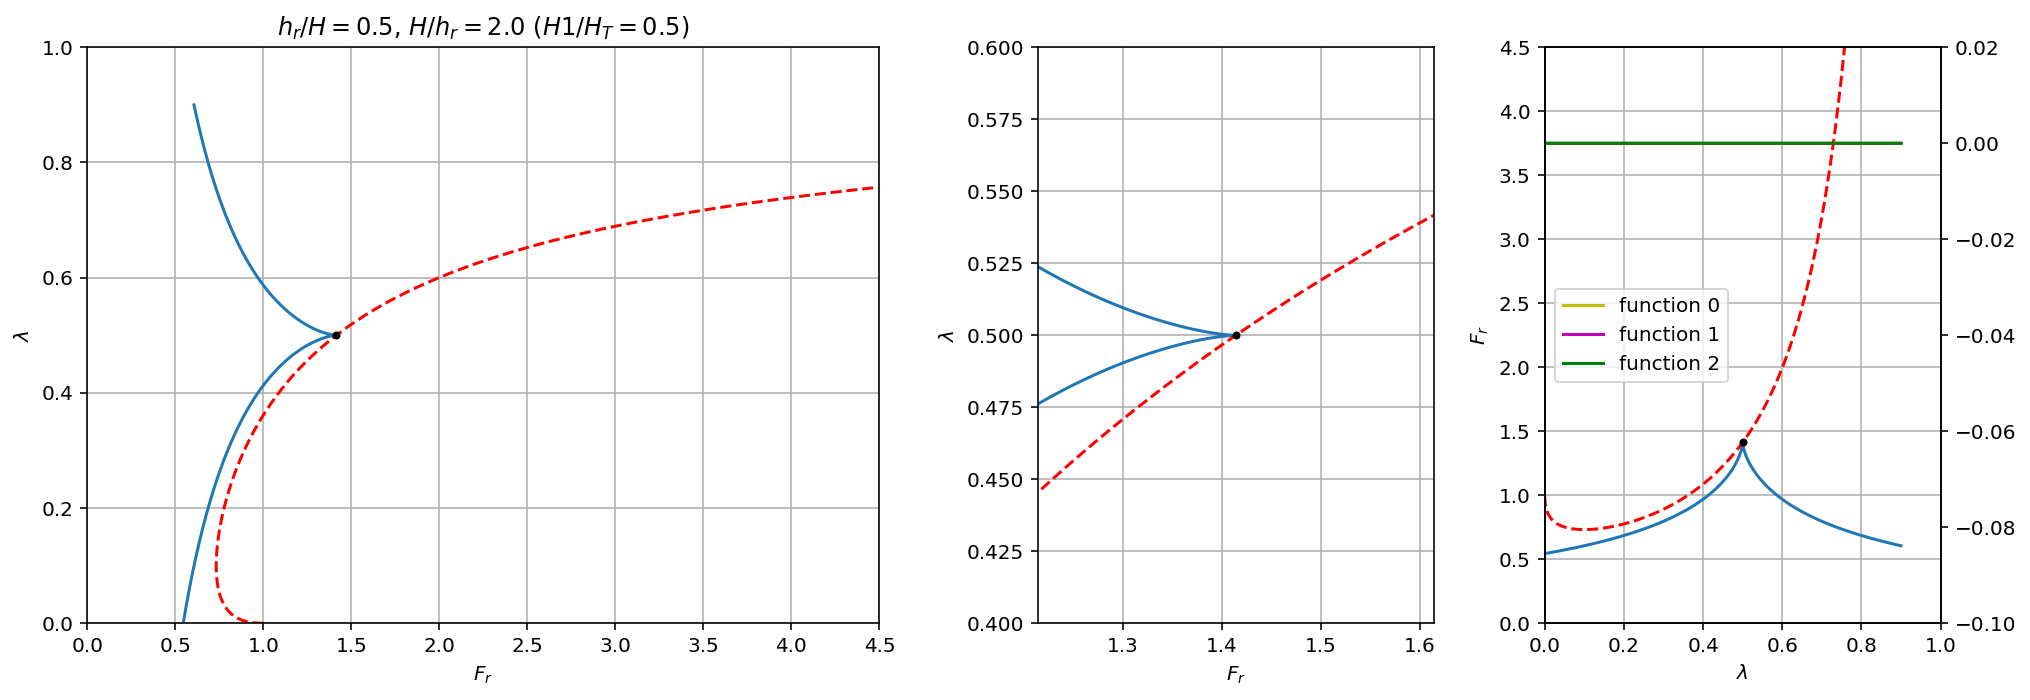

In [7]:
Frmaxtheory = FrmaxJirka(H,hr)

figprops = dict(figsize=(11, 8), dpi=144)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel='$F_r$', ylabel='$\lambda$', title='$h_r/H = {0}$, $H/h_r = {1}$ ($H1/H_T = {2}$)'.format(hr/H,H/hr, (H-hr)/H))
ax.axis([0,4.5,0,1])
ax.grid()

bx = plt.axes([.6, 0, .25, .5])
bx.set(xlabel='$F_r$', ylabel='$\lambda$', title='')
bx.axis([Frmaxtheory-.2,Frmaxtheory+.2,1-hr/H-.1,1-hr/H+.1])
bx.grid()

cx = plt.axes([.92, 0, .25, .5])
cx.set(xlabel='$\lambda$', ylabel='$F_r$', title='')
cx.axis([1-hr/H-.1,1-hr/H+.1,Frmaxtheory-.2,Frmaxtheory+.2])
cx.axis([0,1,0,4.5])
cx.grid()

lammax = np.linspace(0,0.99,1000)
Frmax = pow(1-lammax, -5/2)*pow(1+np.sqrt(lammax/(1-lammax)),-2)
                                                                                                                       
ax.plot(f.Fr, f.lam, '-')
#ax.plot(0.15, 0.24, 'or')
ax.plot(Frmax, lammax, '--r', label='$F_{r_{max}}$')
ax.plot(Frmaxtheory, 1-hr/H, '.k')

bx.plot(f.Fr, f.lam, '-')
bx.plot(Frmax, lammax, '--r', label='$F_{r_{max}}$')
bx.plot(Frmaxtheory, 1-hr/H, '.k')

cx.plot(f.lam, f.Fr, '-')
cx.plot(lammax, Frmax, '--r', label='$F_{r_{max}}$')
cx.plot(1-hr/H, Frmaxtheory, '.k')

cx2 = cx.twinx()
cx2.set_ylim([-0.1,0.02])
cx2.plot(lam_arr, ffun[:,0], 'y', label='function 0')
cx2.plot(lam_arr, ffun[:,1], 'm', label='function 1')
cx2.plot(lam_arr, ffun[:,2], 'g', label='function 2')
cx2.legend(loc='center left')

plt.show()

In [8]:
#hr = 0.25*H
hr_arr = np.array([0.25, 0.375, 0.5, 0.625, 0.75, 0.8])*H
ff = pd.DataFrame({})

for hr in hr_arr:
    print('hr =',hr)
    #lam_arr = np.linspace(0,0.9,10000)
    dlam = 0.0001
    lam_arr = np.concatenate([np.linspace(0,1-hr/H-dlam,1000),
                              np.linspace(1-hr/H-dlam,1-hr/H+dlam,10000),
                              np.linspace(1-hr/H+dlam,0.9,1000)])

    f = pd.DataFrame({'q1': np.zeros(len(lam_arr)),
                      'q2': np.zeros(len(lam_arr)),
                      'hc': np.zeros(len(lam_arr)),
                      'Fr': np.zeros(len(lam_arr)),
                      'lam': lam_arr})
    ffun = np.zeros((len(lam_arr),3))

    q1_ini = 0
    q2_ini = (2/3)**(3/2)*np.sqrt(gp*hr**3)
    hc_ini = 2/3*hr
    fGuess = np.array([q1_ini,q2_ini,hc_ini])
    options = {'ftol': 1e-15, 'maxiter': int(1e6)}
    #options = {'xtol': 0.00001, 'maxfev': int(1e4)} #hybr
    #options = {}
    for ii in progressbar.progressbar(range(len(lam_arr))):
        lam = lam_arr[ii]
        fsol = root(myFunction, fGuess, method='lm', options=options)
        ffun[ii] = fsol.fun
        #print(ii, fsol.message)
        if fsol.success == False:
            print('Failed at step {}'.format(ii))
            print('Iterations: {}'.format(fsol.nfev))
            print('lambda = {}'.format(lam))
            print('message:', fsol.message)
            break
        q1, q2, hc = fsol.x
        f.q1[ii], f.q2[ii], f.hc[ii] = q1, q2, hc
        if (lam < 1-hr/H - dlam) or (lam > 1-hr/H + dlam):
            fGuess = np.array([q1,q2,hc])
        else:
            fGuess = np.array([1-hr/H,q2_ini,hc_ini])

        if lam >= 1-hr/H:
            break

    f['F1'] = f.q1/np.sqrt(gp*(H-f.hc)**3)
    f['F2'] = f.q2/np.sqrt(gp*f.hc**3)
    f['Fr'] = (f.q1+f.q2) / np.sqrt(gp*hr**3)
    f['hr'] = np.ones(len(lam_arr))*hr
    f = f.drop(range(ii+1,len(lam_arr)))
    ff = ff.append(f)

  0% (49 of 12000) |                     | Elapsed Time: 0:00:00 ETA:   0:00:24

hr = 0.25


  1% (152 of 12000) |                    | Elapsed Time: 0:00:00 ETA:   0:00:17

hr = 0.375


  0% (71 of 12000) |                     | Elapsed Time: 0:00:00 ETA:   0:00:16

hr = 0.5


  0% (76 of 12000) |                     | Elapsed Time: 0:00:00 ETA:   0:00:15

hr = 0.625


  0% (72 of 12000) |                     | Elapsed Time: 0:00:00 ETA:   0:00:16

hr = 0.75


  0% (68 of 12000) |                     | Elapsed Time: 0:00:00 ETA:   0:00:17

hr = 0.8


 49% (5979 of 12000) |#########          | Elapsed Time: 0:00:15 ETA:   0:00:17

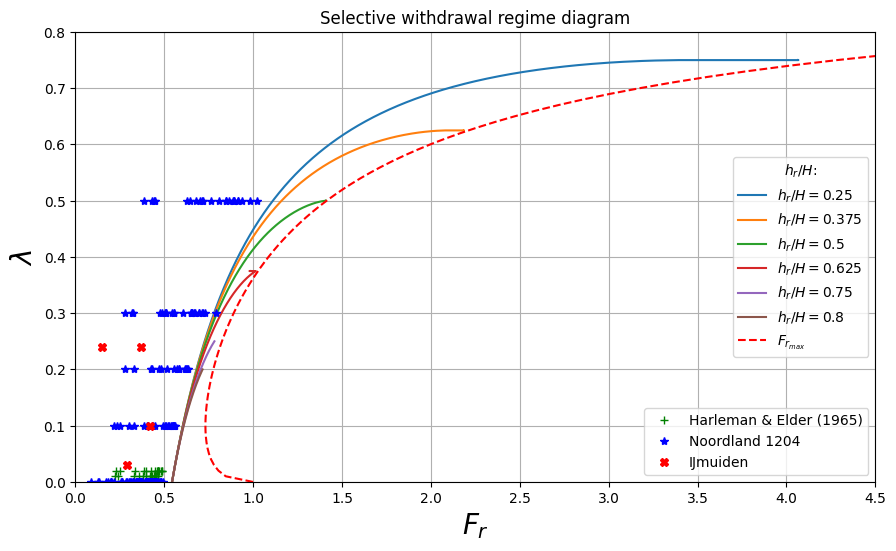

In [22]:
figprops = dict(figsize=(16, 9), dpi=100)
fig = plt.figure(**figprops)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel='$F_r$', ylabel='$\lambda$', title='Selective withdrawal regime diagram')
ax.axis([0,4.5,0,.8])
ax.grid()

[ax.plot(ff.Fr[ff.hr==hr], ff.lam[ff.hr==hr], '-', label='$h_r/H={}$'.format(hr/H)) for hr in hr_arr]
lammax = np.linspace(0,0.99,100)
Frmax = pow(1-lammax, -5/2)*pow(1+np.sqrt(lammax/(1-lammax)),-2)
ax.plot(Frmax, lammax, '--r', label='$F_{r_{max}}$')

lgnd1 = ax.legend(title='$h_r/H$:', loc='center right')

HaElplot, = ax.plot(pd.concat([HaEl1.Fr, HaEl2.Fr]), pd.concat([HaEl1.lam, HaEl2.lam]), '+g')
#sel = np.where(NL1204.D<2/3*NL1204.hr)[0]
#NL1204plot, = ax.plot(NL1204.iloc[sel].Fr, NL1204.iloc[sel].lam, '*b')
NL1204plot, = ax.plot(NL1204.Fr, NL1204.lam, '*b')
IJplot, = ax.plot(IJ.Fr, IJ.lam, 'Xr')
lgnd2 = ax.legend([HaElplot, NL1204plot, IJplot], ['Harleman & Elder (1965)', 'Noordland 1204', 'IJmuiden'], loc='lower right')
ax.add_artist(lgnd1)

plt.show()

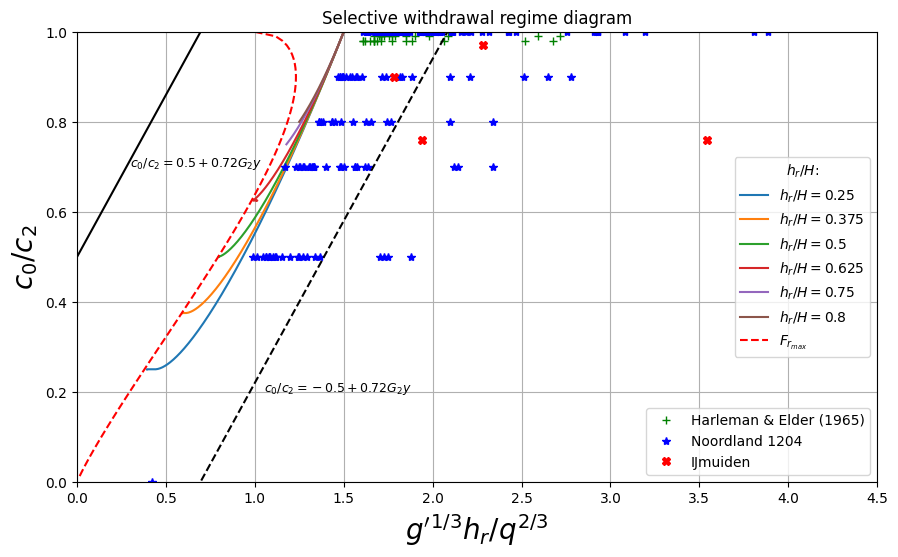

In [55]:
figprops = dict(figsize=(16, 9), dpi=100)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel="$g'^{1/3}h_r/q^{2/3}$", ylabel='$c_0/c_2$', title='Selective withdrawal regime diagram')
ax.axis([0,4.5,0,1])
ax.grid()

[ax.plot(pow(ff.Fr[ff.hr==hr],-2/3), 1-ff.lam[ff.hr==hr], '-', label='$h_r/H={}$'.format(hr/H)) for hr in hr_arr]
lammax = np.linspace(0,0.99,100)
Frmax = pow(1-lammax, -5/2)*pow(1+np.sqrt(lammax/(1-lammax)),-2)
ax.plot(pow(Frmax,-2/3), 1-lammax, '--r', label='$F_{r_{max}}$')

lgnd1 = ax.legend(title='$h_r/H$:', loc='center right')

HaElplot, = ax.plot(pd.concat([pow(HaEl1.Fr,-2/3), pow(HaEl2.Fr,-2/3)]), pd.concat([1-HaEl1.lam, 1-HaEl2.lam]), '+g')
#sel = np.where(NL1204.D<2/3*NL1204.hr)[0]
#NL1204plot, = ax.plot(NL1204.iloc[sel].Fr, NL1204.iloc[sel].lam, '*b')
NL1204plot, = ax.plot(pow(NL1204.Fr,-2/3), 1-NL1204.lam, '*b')
IJplot, = ax.plot(pow(IJ.Fr,-2/3), 1-IJ.lam, 'Xr')
lgnd2 = ax.legend([HaElplot, NL1204plot, IJplot], ['Harleman & Elder (1965)', 'Noordland 1204', 'IJmuiden'], loc='lower right')
ax.add_artist(lgnd1)

xFan = np.linspace(-1.2,5,1000)
c0c2Fan = (-0.5 + 0.72*xFan)
ax.plot(xFan, c0c2Fan, '--k')
ax.text(1.05,0.2,'$c_0/c_2=-0.5+0.72G_2y$', fontdict={'size': 9})

xFan = np.linspace(-1.2,5,1000)
c0c2Fan = (0.5 + 0.72*xFan)
ax.plot(xFan, c0c2Fan, 'k')
ax.text(.3,0.7,'$c_0/c_2=0.5+0.72G_2y$', fontdict={'size': 9})

plt.show()

In [53]:
IJ

,experiment,rhofrac,lam,Fr,Q1,q1,Q2,q2,q,level interface inlet,level interface screen,hr/H,H,hr
0,100A,0.015864,0.24,0.15,2.3,0.001153,7.6,0.003810,0.004962,-374.3,-389.9,0.32,0.573382,0.183482
1,300C,0.015864,0.03,0.29,1.0,0.000501,28.6,0.014336,0.014837,-315.6,-323.3,0.44,0.577321,0.254021
2,300D,0.015864,0.10,0.42,3.0,0.001504,26.6,0.013333,0.014837,-356.0,-376.6,0.35,0.579385,0.202785
3,300F,0.015864,0.24,0.37,7.0,0.003509,22.6,0.011328,0.014837,-334.4,-358.1,0.38,0.577581,0.219481


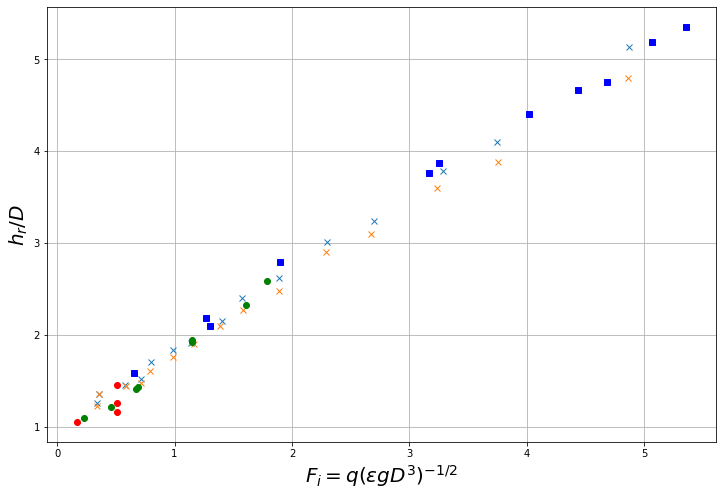

In [52]:
plt.figure(figsize=(12,8))
plt.plot(HaEl1.q/HaEl1.D/np.sqrt(HaEl1.rhofrac*9.81*HaEl1.D), HaEl1.hr/HaEl1.D, 'x')
plt.plot(HaEl2.q/HaEl2.D/np.sqrt(HaEl2.rhofrac*9.81*HaEl2.D), HaEl2.hr/HaEl2.D, 'x')

sel = np.arange(0,27) #referentieproeven D=3.1, L=1.35m, Drho=20
sel3 = NL1204.iloc[sel].iloc[np.where(NL1204.iloc[sel].lam==0)] #alle waar lambda=0
plt.plot(sel3.q/sel3.D/np.sqrt(sel3.rhofrac*9.81*sel3.D), 
         sel3.hr/sel3.D, 'sb')

sel = np.arange(27,47) #referentieproeven D=6.1cm, L=1.35m, Drho=20
sel6 = NL1204.iloc[sel].iloc[np.where(NL1204.iloc[sel].lam==0)] #alle waar lambda=0
plt.plot(sel6.q/sel6.D/np.sqrt(sel6.rhofrac*9.81*sel6.D), 
         sel6.hr/sel6.D, 'og')

DIJ = 17.5e-2
plt.plot(IJ.q/DIJ/np.sqrt(IJ.rhofrac*9.81*DIJ), 
         IJ.hr/DIJ, 'or')

plt.gca().set(xlabel="$F_i = q (\epsilon g D^3)^{-1/2}$", ylabel="$h_r/D$")

plt.grid()

# Comparing with Fan

$\frac{c_0}{c_2} = \frac{1}{2}\left[ 1-\frac{g'^{1/3}y}{K_2 q^{2/3}}\right]$ \
$\frac{c_0}{c_2} \approx \frac{q_2}{q_0} = \frac{q_2}{q} = \frac{q_2}{q_1+q_2} = 1-\frac{q_1}{q} = 1-\lambda$\
So: \
$\lambda = 1 - \frac{1}{2}\left[ 1-\frac{g'^{1/3}y}{K_2 q^{2/3}}\right]$\
Rewritten:\
$y = (2\lambda - 1) \frac{K_2q^{2/3}}{g'^{1/3}}$,\
with $K_2 = \frac{g'^{1/3}h_L}{q^{2/3}}$, this becomes \
$y = (2\lambda-1)h_L$

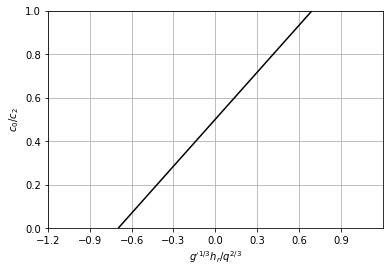

In [66]:
xFan = np.linspace(-1.2,5,1000)
c0c2Fan = (0.5 + 0.72*xFan)
fig, ax = plt.subplots(1,1)
ax.plot(xFan, c0c2Fan, 'k')
ax.grid()
ax.set(xlabel="$g'^{1/3}h_r/q^{2/3}$", ylabel="$c_0/c_2$")
ax.axis([-1.2,1.2,0,1])
ax.set_xticks(np.arange(-1.2,1.2,0.3))

#ax.invert_xaxis()

<ipython-input-299-efec29fcf2ff>:3: RuntimeWarning: invalid value encountered in power
  Fan = pd.DataFrame({'lam': lamFan, 'Fr': pow(K*(2*lamFan-1),-3/2)})


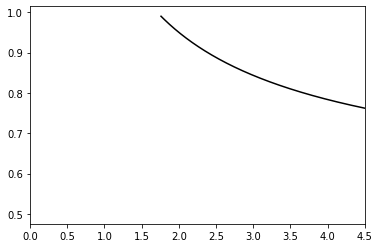

In [299]:
K = 0.7
lamFan = np.linspace(0.01,0.99,10000)
Fan = pd.DataFrame({'lam': lamFan, 'Fr': pow(K*(2*lamFan-1),-3/2)})
plt.plot(Fan.Fr, Fan.lam, 'k')
plt.xlim([0,4.5])
plt.show()

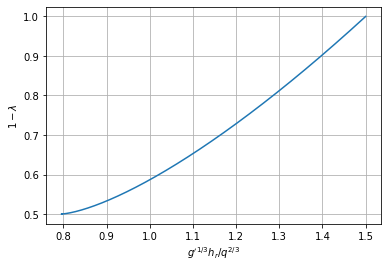

In [40]:
x = gp**(1/3)*hr/pow(f.q1+f.q2,2/3)
plt.plot(x[:20000], 1-f.lam[:20000])

#plt.axis([-0.5,0.5,0,1])
plt.gca().set(xlabel="$g'^{1/3}h_r/q^{2/3}$", ylabel='$1-\lambda$', title='')
plt.grid()

[Text(0.5, 0, '$h_r/h_c$'), Text(0, 0.5, '$\\lambda$')]

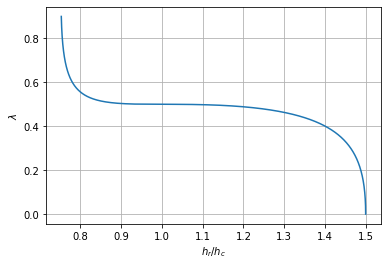

In [51]:
plt.plot(hr/f.hc, f.lam)
plt.grid()
plt.gca().set(xlabel="$h_r/h_c$", ylabel="$\lambda$")

In [53]:
c = pd.DataFrame({'lam': np.array([0.24, 0.03, 0.1, 0.24]),
                  'q': np.array([9.9, 29.6, 29.6, 29.6])*1e-3/199.5e-2,
                  'y': np.array([15.6, 7.7, 20.6, 23.7])*1e-3,
                  'Fr': np.array([0.15, 0.29, 0.42, 0.37])})

In [55]:
c

,lam,q,y,Fr
0,0.24,0.004962,0.0156,0.15
1,0.03,0.014837,0.0077,0.29
2,0.10,0.014837,0.0206,0.42
3,0.24,0.014837,0.0237,0.37


[Text(0.5, 0, '$q_2/q$'), Text(0, 0.5, '$F_r$')]

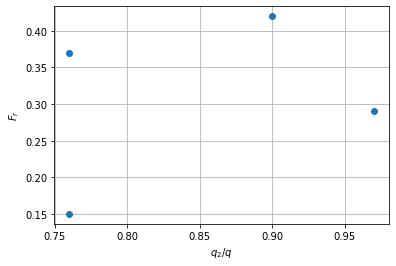

In [62]:
plt.plot(1-c.lam, c.Fr, 'o')
plt.grid()
plt.gca().set(xlabel='$q_2/q$', ylabel='$F_r$')

In [13]:
c

,lam,q,y,Fr
0,0.24,4962.406015,0.0156,0.15
1,0.03,14837.092732,0.0077,0.29
2,0.10,14837.092732,0.0206,0.42
3,0.24,14837.092732,0.0237,0.37


[Text(0.5, 0, "$g'^{1/3}y/q^{2/3}$"), Text(0, 0.5, '$c_0/c_2$')]

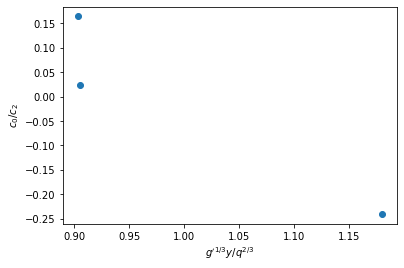

In [72]:
table4 = pd.DataFrame({'a': np.array([0.67,0.53,0.42]),
                      'b': np.array([0.56,0.56,0.56]),
                      'hL': np.array([13.9,14.6,11.8]),
                      'G2': np.array([0.065,0.062,0.1])})
table4['c0c2'] = table4.a-table4.b*table4.G2*table4.hL
table4
plt.plot(table4.G2*table4.hL, table4.c0c2, 'o')
plt.gca().set(xlabel="$g'^{1/3}y/q^{2/3}$", ylabel="$c_0/c_2$")